In [1]:
import numpy as np

bbox_worldcord = [25, 25, 25, 0, 0, 0] # [x,y,z, roll, pitch, yaw]
ego_vehicle_worldcord = [5,5,5,90,0,45] # [x,y,z, roll, pitch, yaw]

def bbox_to_ego(bbox_worldcord:list =[0,0,0,0,0,0], ego_vehicle_worldcord:list =[0,0,0,0,0,0]):
    # bbox_worldcord and ego_vehicle_worldcord are in format [x,y,z, roll, pitch, yaw] (degrees)
    
    def rotation_matrix(roll, pitch, yaw):
        roll = roll * np.pi / 180
        pitch = pitch * np.pi / 180
        yaw = yaw * np.pi / 180

        Rx = np.array([[1, 0, 0],
                       [0, np.cos(roll), -np.sin(roll)],
                       [0, np.sin(roll), np.cos(roll)]])
        
        Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                       [0, 1, 0],
                       [-np.sin(pitch), 0, np.cos(pitch)]])
        
        Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                       [np.sin(yaw), np.cos(yaw), 0],
                       [0, 0, 1]])
        
        return Rz @ Ry @ Rx 
    Re = rotation_matrix(ego_vehicle_worldcord[3], ego_vehicle_worldcord[4], ego_vehicle_worldcord[5])

    Rw = rotation_matrix(bbox_worldcord[3], bbox_worldcord[4], bbox_worldcord[5])
    
    Rbe = Re.T @ Rw
    
    bbox_ego_coords = Re.T @ (np.array(bbox_worldcord[0:3]) - np.array(ego_vehicle_worldcord[0:3]))
    bbox_ego_rotation = np.array([
        np.arctan2(Rbe[2,1], Rbe[2,2]),
        np.arcsin(-Rbe[2,0]),
        np.arctan2(Rbe[1,0], Rbe[0,0])]
    )

    bbox_ego_rotation = bbox_ego_rotation * 180 / np.pi

    return bbox_ego_coords, bbox_ego_rotation

newcord, newrot = bbox_to_ego(bbox_worldcord,ego_vehicle_worldcord)
print(newrot)

[-9.00000000e+01 -4.50000000e+01 -3.50835465e-15]


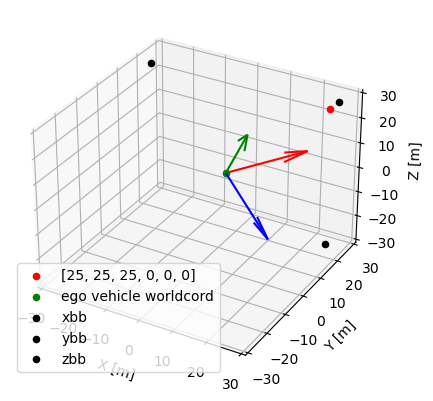

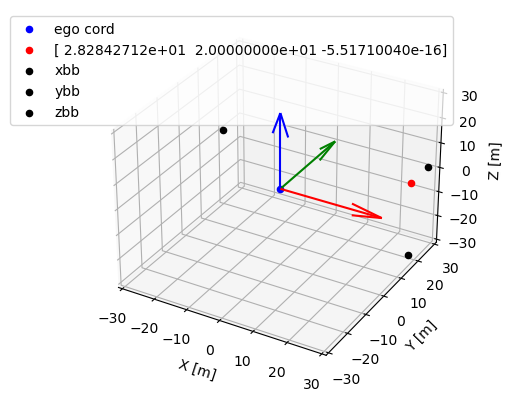

In [2]:
#plot the worldcord and ego coord
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bbox_worldcord[0], bbox_worldcord[1], bbox_worldcord[2], c='r', label=f'{bbox_worldcord}')
ax.scatter(ego_vehicle_worldcord[0], ego_vehicle_worldcord[1], ego_vehicle_worldcord[2], c='g', label='ego vehicle worldcord')
bbox_ego_coords, bbox_ego_rotation = bbox_to_ego(bbox_worldcord, ego_vehicle_worldcord)
#put rotation arrows to the ego car showing the roll, pitch, yaw of the ego vehicle in worldcord
def euler_to_matrix(roll, pitch, yaw):
    # Roll (x), pitch (y), yaw (z), angles given in radians
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    # Apply in ZYX: yaw, pitch, roll
    return Rz @ Ry @ Rx

R = euler_to_matrix(ego_vehicle_worldcord[3], ego_vehicle_worldcord[4], ego_vehicle_worldcord[5])

# Local basis vectors
axes = np.eye(3)  # unit x, y, z

# Draw 3 arrows for the rotated local axes from the point
for i, color in enumerate(['r', 'g', 'b']):  # x, y, z axes
    dir_vec = R @ axes[:,i]
    ax.quiver(*ego_vehicle_worldcord[0:3], *dir_vec, length=25, color=color)





ax.scatter(bbox_worldcord[0], bbox_worldcord[1],-30, c='black', label='xbb')
ax.scatter(-30, bbox_worldcord[1],bbox_worldcord[2], c='black', label='ybb')
ax.scatter(bbox_worldcord[0], 30,bbox_worldcord[2], c='black', label='zbb')


#ax.scatter(bbox_ego_coords[0], bbox_ego_coords[1], bbox_ego_coords[2], c='b', label='bbox ego cord')
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0, 0, 0, c='b', label='ego cord')
ax.quiver(0,0,0 , 1,0,0, length=30, color='r', normalize=True)
ax.quiver(0,0,0, 0,1,0, length=30, color='g', normalize=True)
ax.quiver(0,0,0, 0,0,1, length=30, color='b', normalize=True)
ax.scatter(bbox_ego_coords[0], bbox_ego_coords[1], bbox_ego_coords[2], c='r', label=f'{bbox_ego_coords}')
ax.scatter(bbox_ego_coords[0], bbox_ego_coords[1],-30, c='black', label='xbb')
ax.scatter(-30, bbox_ego_coords[1],bbox_ego_coords[2], c='black', label='ybb')
ax.scatter(bbox_ego_coords[0], 30,bbox_ego_coords[2], c='black', label='zbb')
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.legend()
plt.show()

In [3]:
new_coords, new_rotation = bbox_to_ego(bbox_worldcord, ego_vehicle_worldcord)
print("New Coordinates in Ego Frame:", new_coords)
print("New Rotation in Ego Frame (roll, pitch, yaw):", new_rotation)

New Coordinates in Ego Frame: [ 2.82842712e+01  2.00000000e+01 -5.51710040e-16]
New Rotation in Ego Frame (roll, pitch, yaw): [-9.00000000e+01 -4.50000000e+01 -3.50835465e-15]


In [4]:
import h5py
import numpy as np
to_type ={
  0 : "Unlabeled",
  1 : "Roads",
  2 : "SideWalks",
  3 : "Buildings",
  4 : "Wall",
  5 : "Fence",
  6 : "Pole",
  7 : "TrafficLight",
  8 : "TrafficSign",
  9 : "Vegetation",
  10 : "Terrain",
  11 : "Sky",
  12 : "Pedestrian",
  13 : "Rider",
  14 : "Car",
  15 : "Truck",
  16 : "Bus",
  17 : "Train",
  18 : "Motorcycle",
  19 : "Bicycle",
  20 : "Static",
  21 : "Dynamic",
  22 : "Other",
  23 : "Water",
  24 : "RoadLine",
  25 : "Ground",
  26 : "Bridge",
  27 : "RailTrack",
  28 : "GuardRail", 
}
with h5py.File('/home/npopkov/repos/IR2025/data/251119_eight_lidar_10s/db/lidar_data.h5', 'r') as f, h5py.File('/home/npopkov/repos/IR2025/data/251119_eight_lidar_10s/bbox.h5', 'r') as f_bbox:
    print(f.keys())
    print(len(f['_carla_ego_vehicle_lidar_front'].keys()))
    print(len(f_bbox.keys()))
    actors = list(f_bbox['frame_000006']['actors'])
    print(actors)
    ids = []
    uuids = []
    for i in range(10032):
        id = f['_carla_ego_vehicle_lidar_right']['frame_000000'][i][-1]
        uuid = f['_carla_ego_vehicle_lidar_right']['frame_000000'][i][-2]
        uuids.append(uuid)
        ids.append(id)

    print(set(ids))
    print(set(uuids))
    for id in set(ids):
        print(to_type[id])

<KeysViewHDF5 ['_carla_ego_vehicle_lidar_front', '_carla_ego_vehicle_lidar_front_left', '_carla_ego_vehicle_lidar_front_right', '_carla_ego_vehicle_lidar_left', '_carla_ego_vehicle_lidar_rear', '_carla_ego_vehicle_lidar_rear_left', '_carla_ego_vehicle_lidar_rear_right', '_carla_ego_vehicle_lidar_right', 'metadata2']>
207
201
[array([ 1.97000000e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.39588976e+00,  1.08172500e+00,  7.43830025e-01,  0.00000000e+00,
       -0.00000000e+00, -2.70340000e-21]), array([ 2.13000000e+02, -1.56245329e-03,  2.93749940e-02,  3.77273560e-03,
        2.09641504e+00,  9.08092916e-01,  7.36915588e-01,  0.00000000e+00,
       -0.00000000e+00,  1.79999687e+02]), array([ 2.16000000e+02, -5.46830041e-04,  2.78906258e-02,  2.78611004e-01,
        2.24021840e+00,  1.03465760e+00,  1.01889598e+00,  0.00000000e+00,
       -0.00000000e+00, -2.70340000e-21]), array([ 2.64000000e+02, -7.81202884e-04,  2.92187513e-02, -6.90662861e-02,
        2.51338840

KeyError: b'SideWalks'

In [ ]:
{1, 2, 5, 14, 20}
Roads
SideWalks
Fence
Car
Static